# 1. Trabajo Práctico N°2: de Analisis + Curación

# Trabajo Práctico N°2: Análisis Exploratorio y Curación de Datos

## Introducción

Este trabajo práctico intenta continuar la exploración de los datasets planteados en el [primer trabajo práctico](https://github.com/luisdvlpr/diplodatos2021-datasets/blob/main/TP1_Analisis_y_Visualizacion/enunciado_tp1_analisis_y_visualizacion.ipynb)

En el primer práctico pudimos notar algunas características propias de las series temporales y en particular del dominio del comportamiento de un ecommerce genérico. Muchas de ellas son __series no estacionarias__, ya que la caracterización de estas distribuciones ( media, varianza ) cambian a través del tiempo y se observan ademas alguna tendencias. __Por otra parte se se distinguen patrones de estacionalidad, por ej. semanal__. 

Lo anterior trae __consecuencias__ directas en la selección de las metodologías adecuadas para abordar las problemáticas de tratamiento de __valores faltantes__, detección de __outliers__ y la construcción de __modelos predictivos__.

Por otra parte, debe notarse que el tamaño de las economías de cada pais y la adopción de los hábitos de uso de estas plataformas en cada uno de ellos hace que el uso de cantidad de sesiones no sea una medida adecuada para compararles. Entonces, el análisis de estas series se centra por lo general en el cambio porcentual de los precios en vez del cambio en los valores absolutos. Esto resulta en que en vez de modelar los índices originales, previamente se habitúa realizar una __transformación logarítmica__ o trabajar con la __tasa de conversión__ a fin de expresarlos en un __único métrica que les caracterice__ para evitar distorsiones debidas a los tamaños de sus economías y hábitos de uso.

# Consignas del trabajo práctico N°2

El objetivo general del práctico es realizar algunas tareas de __preprocesamiento__ de los datos y luego __analizar las series obtenidas__ de dicho preprocesamiento en forma similar a la empleada en el TP1.

Se proponen las siguientes actividades orientadoras, sin perjuicio de que se puedan incorporar análisis adicionales:

#### Tratamiento de faltantes

- Identificar valores perdidos, huecos en los datos ej: aquellos días para los que no hubo datos

- Identificar aquellos valores "sospechosos", debido al dropout ( o perdida de sesiones) a medidas que avanzas en 
  las pantallas la cantidad de sesiones en la pantalla posterior es menor/igual al de su predecesora

- Imputar los valores sospechoso con otros que tengan sentido dentro del dominio segun lo explicado en el punto anterior

- Imputar los faltantes debidos a fallas de medición usando un algoritmo adecuado para series temporales, 
  por ejemplo splines, interpolaciones, valores de medias/medianas móviles por ventana de tiempo

- Comparar los valores originales vs los imputados y juzgue si los valores se mantienen dentro de parametros aceptables, ¿Como justificaría que dichos valores imputados tienen sentido en su analisis?


#### Transformaciones

Obtener las siguientes series transformadas:

- Los logaritmos naturales de los índices. 

- Las tasas de conversion.

#### Exploración de las series transformadas

Reutilizar parte del código del TP1 para analizar las series transformadas. En una primera etapa se puede trabajar con solo una de las series resultantes de tomar logaritmo natural y una serie de tasa de conversión.

- Analizar las distribuciones por medio de gráficos y medidas de estadística descriptiva.

- Dichas distribuciones, ¿se mantienen relativamente inalteradas en el tiempo?

- ¿Hay outliers?

- Estudiar la evolución temporal de las series. ¿En qué sentido tienden a moverse? ¿Tienden a moverse en forma conjunta?  ¿Siempre se da dicho patrón? ¿Hay períodos de crisis? En caso de que existan crisis / eventos , ¿Son globales o propias de sites individuales? 

- To Be defined: De ser definido, podemos establecer un grupo de control versus ls valores imputados y establecer 
  que tan buenos resultaron los métodos ejecutados para rellenar los valores respecto de los deseables

#### Opcional
- Graficar e interpretar las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF).
- Explorar la volatilidad de las series, por ejemplo graficando las desviaciones estándar móviles.

## Fecha de entrega

- __Versión preliminar: 03/07__ 

- __Version final: 07/07__

## Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis realizado. El mismo puede orientarse para un público técnico pero que desconoce los aspectos propios del problema como sus compañeros de clase. Dicho informe puede ser un notebook, a condición de que en el mismo se explique un análisis escrito suficientemente detallado de los resultados. 


### ***1- CARGA DEL DATASET***

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#Algunas configuraciones generales para el desarrollo del trabajo
plt.rcParams['figure.figsize'] = (12, 9)
pd.options.display.float_format = '{:20,.2f}'.format #configuración para sacar la notación cientifica

Carga de los datos originales:

In [3]:
data_orig = pd.read_csv(
    'https://raw.githubusercontent.com/luisepifanio/diplodatos2021-datasets/main/TP2_Analisis_y_Curacion/datasets/traffic_AR_CL_UY.csv', 
    usecols = ["Fecha", "flow", "Site", "Device", "Loading", "Shipping", "Payments", "Review", "Congrats"], 
    parse_dates=["Fecha"],index_col=["Fecha"])
traffic_data=data_orig.copy()

In [4]:
#Filtramos los datos para trabajar solo con los datos correspondientes a Mercado libre Argentina (MLA),
#flujo directo, desktop y android.

traffic_data = traffic_data[traffic_data.Site==("MLA")]
traffic_data = traffic_data[traffic_data.flow==("direct")]
traffic_data = traffic_data[(traffic_data.Device==("Android"))|(traffic_data.Device==("Desktop"))]

#Agrupamos las columnas que corresponden a las etapas de compra de interés 
#(excluimos del análisis a "loading" por falta de relevancia. 
cols_etapas = ['Shipping', 'Payments', 'Review', 'Congrats']

Una vez que tenemos cargado el dataset original, se procede a investigar la calidad de los datos. Para esto, se buscan valores nulos, faltantes y outliers.

### ***2- DATOS FALTANTES***

En un primer momento se identifican los valores faltantes dentro del dataset, denominados como "NaN" ("Not a number"). Esto puede haber sucedido por una falla en la medición, o por algún problema en el procesamiento de los mismos.

In [5]:
#Localizamos los datos faltantes según el tipo de DEVICE
traffic_data.drop('Device', 1).isna().groupby(traffic_data.Device, sort=False).sum()

flow  Site  Loading  Shipping  Payments  Review  Congrats
Device                                                            
Android     0     0        0         1         0       2         0
Desktop     0     0        0         0         0       0         0

Solo tres datos aparecen como faltantes en el dataset, uno en la etapa "Shipping" y dos de ellos en la etapa "Review". Los tres pertenecen al device ANDROID. En DESKTOP no se presentan datos faltantes.

In [6]:
#Localizamos los datos faltantes en el dataset original
traffic_data[cols_etapas][traffic_data['Shipping'].isnull()|traffic_data['Review'].isnull()]

Shipping  Payments               Review  Congrats
Fecha                                                                   
2019-03-22           169,846.00    138177                  nan     89890
2019-05-07                  nan    172472           121,321.00    113250
2019-08-27           223,993.00    180928                  nan    113464

Podemos identificar que los 3 datos faltantes corresponden a los devices Android sin estar correlacionados entre sí, para 3 fechas diferentes: 22 de marzo, 7 de mayo y 27 de agosto de 2019.

### ***3- DATOS NULOS***

Otro caso que puede surgir es que los valores del dataset no sean missing values, sino datos nulos, es decir, observaciones iguales a cero. En este caso, y si no surge del conocimiento de dominio que esto sea correcto por algún hecho puntual, estos ceros deben ser identificados y luego imputados con valores acorde al dominio.

In [7]:
#Buscamos los datos nulos e identificamos en qué columnas se encuentran.
cols_null = traffic_data[traffic_data == 0].count(axis=0)
cols_null[cols_null > 0]

Loading     4
Shipping    4
Payments    4
Review      4
Congrats    4
dtype: int64

In [8]:
#Buscamos en el dataset el conjunto de datos correspondientes a los casos donde se encuentran
#los valores nulos
columns = traffic_data.columns.tolist()
columns
traffic_data_null = traffic_data[(traffic_data.iloc[:,:] == 0).any(axis=1)]
traffic_data_null

flow Site   Device  Loading             Shipping  Payments  \
Fecha                                                                      
2019-12-05  direct  MLA  Android        0                 0.00         0   
2019-12-05  direct  MLA  Desktop        0                 0.00         0   
2019-12-06  direct  MLA  Android        0                 0.00         0   
2019-12-06  direct  MLA  Desktop        0                 0.00         0   

                         Review  Congrats  
Fecha                                      
2019-12-05                 0.00         0  
2019-12-05                 0.00         0  
2019-12-06                 0.00         0  
2019-12-06                 0.00         0

Podemos afirmar que solo hay dos fechas con valores iguales a 0. Ambos se corresponden a los mismos días tanto para Android como para Desktop: 5 y 6 de diciembre de 2019. Dos días consecutivos. Podemos pensar que el motivo es alguna falla en la toma de datos generales de Mercado Libre Argentina que impactó en ambos devices. 
En ambos casos, todas las etapas son 0, por ello los convertiremos en NaN y luego los imputaremos.

In [9]:
#Reemplazamos los valos nulos por NaN
traffic_data = traffic_data.replace([0], np.nan)

In [10]:
#Verificamos
traffic_data['2019-12-05':'2019-12-06'][cols_etapas]

Shipping             Payments               Review  \
Fecha                                                                       
2019-12-05                  nan                  nan                  nan   
2019-12-05                  nan                  nan                  nan   
2019-12-06                  nan                  nan                  nan   
2019-12-06                  nan                  nan                  nan   

                       Congrats  
Fecha                            
2019-12-05                  nan  
2019-12-05                  nan  
2019-12-06                  nan  
2019-12-06                  nan

####  ***4- VALORES PERDIDOS***

Otra instancia en la limpieza y el preprocesamiento de datos cuando se trabaja con series de tiempo implica identificar si la serie saltea una o más fechas. 

In [11]:
traffic_data_android = traffic_data[traffic_data.Device==("Android")]
traffic_data_desktop = traffic_data[traffic_data.Device==("Desktop")]

traffic_data_len = traffic_data.index.nunique()
print("El periodo de tiempo analizado es de",  traffic_data_len , "días.")

traffic_data_len_android = len(traffic_data_android.index)
traffic_data_len_desktop = len(traffic_data_android.index)

print("En Android tenemos:", traffic_data_len_android,"y en Desktop:", traffic_data_len_desktop, "por lo que concluímos que los datasets de ambos devices estan completos.")

El periodo de tiempo analizado es de 488 días.
En Android tenemos: 488 y en Desktop: 488 por lo que concluímos que los datasets de ambos devices estan completos.


### ***5- DATOS SOSPECHOSOS***

Habiendo ya identificado los valores problemáticos más evidentes, analizaremos las series de datos para identificar valores sospechosos, ya con conocimiento de dominio.
En primer lugar se verá si existen fechas en las cuales la lógica de funnel no se cumple, es decir, que en una etapa posterior del proceso de compra se cuenta con más transacciones que en una etapa anterior. Para ello se calculan las tasas de conversión entre las etapas y se verifica si hay alguna superior a uno.

In [12]:
#Agregamos columnas relativas a las tasas de conversión entre las diferentes etapas de compra

df_traffic=traffic_data.copy()
df_traffic["Shipping-Payments"] = df_traffic["Payments"] / df_traffic["Shipping"]
df_traffic["Payments-Review"] = df_traffic["Review"] / df_traffic["Payments"]
df_traffic["Review-Congrats"] = df_traffic["Congrats"] / df_traffic["Review"]
df_traffic["Shipping-Congrats"] = df_traffic["Congrats"] / df_traffic["Shipping"]

#Agrupamos las columnas de índices para evaluar su comportamiento por separado de las etapas
cols_indices = ['Shipping-Payments', 'Payments-Review', 'Review-Congrats', 'Shipping-Congrats']

#Agregamos columnas relativas a las fechas ya que nos interesa el comportamiento temporal
df_traffic["Weekday"] = df_traffic.index.day_name()
df_traffic["Month"] = df_traffic.index.month_name()
df_traffic["Year"] = df_traffic.index.year
new = df_traffic["Month"].copy().astype(str)
new1 = df_traffic["Year"].copy().astype(str)
df_traffic["Months"]= new.str.cat(new1, sep ="-")



In [13]:
#Buscamos en el dataset observaciones que no cumplan con la lógica del funnel, es decir,
#que presenten en una etapa previa menos observaciones que en una posterior
columns = df_traffic.columns.tolist()
columns
df_traffic_sospechoso = df_traffic[(df_traffic[cols_indices].iloc[:,:] > 1).any(axis=1)]
df_traffic_sospechoso

Empty DataFrame
Columns: [flow, Site, Device, Loading, Shipping, Payments, Review, Congrats, Shipping-Payments, Payments-Review, Review-Congrats, Shipping-Congrats, Weekday, Month, Year, Months]
Index: []

Como se puede observar en la última celda, no se identificaron casos en los cuales una tasa de conversión fuera superior a uno. Es por ello que procederemos a analizar si existen outliers en el dataset que deban ser tratados.

In [14]:
df_traffic[cols_etapas].describe()

Shipping             Payments               Review  \
count               971.00               972.00               970.00   
mean            181,541.90           148,428.32           103,622.26   
std             102,431.53            82,304.53            54,368.80   
min              28,722.00             3,823.00             2,597.00   
25%             114,433.00            96,055.25            71,472.25   
50%             162,331.00           130,287.50            90,169.50   
75%             234,561.00           189,188.00           133,115.75   
max             537,723.00           444,330.00           286,162.00   

                  Congrats  
count               972.00  
mean             97,196.05  
std              49,451.14  
min               2,538.00  
25%              68,528.50  
50%              85,017.00  
75%             124,910.25  
max             264,742.00

Llaman la atención los valores mínimos de las etapas Payments, Review y Congrats, ya que son sustancialmente inferiores a los valores normales para estas transacciones. A continuación ubicamos los mismos temporalmente.

In [15]:
traffic_data[(traffic_data['Payments']<3900)|(traffic_data['Review']<2600)|(traffic_data['Congrats']<2600)]

flow Site   Device              Loading             Shipping  \
Fecha                                                                        
2019-12-04  direct  MLA  Desktop           146,932.00           138,124.00   

                       Payments               Review             Congrats  
Fecha                                                                      
2019-12-04             3,823.00             2,597.00             2,538.00

Todos estos valores atípicos se dieron el 4 de Diciembre de 2019, un día antes de que el dataset presentara datos nulos en todas sus etapas durante dos días. En el siguiente boxplot puede verse que los mismos son outliers y, por consiguiente, se procederá a reemplazarlos por valores nulos para su posterior imputación.

Text(0.5, 1.0, 'Etapas')

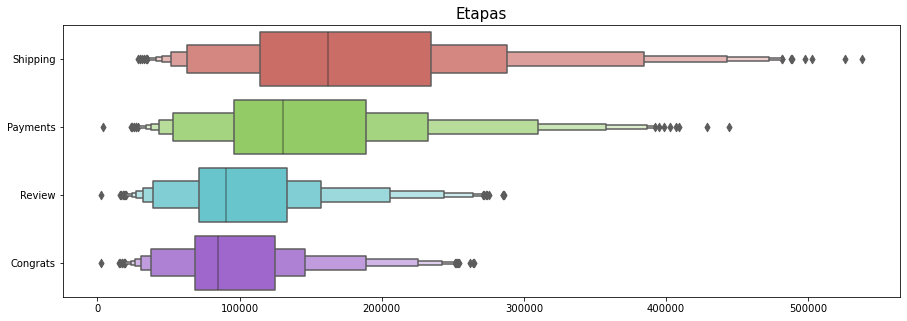

In [16]:
#Verificamos con un boxenplot que dichos mínimos son outliers
plt.rcParams['figure.figsize'] = (15, 5)
sns.boxenplot(data=traffic_data[cols_etapas], orient = "h", palette='hls')
plt.title('Etapas', size=15)

In [17]:
#Reemplazamos los valores minimos por NaNs
df_traffic = df_traffic.replace([3823, 2597, 2538], np.nan)

In [18]:
#Verificamos
df_traffic['2019-12-04':'2019-12-04'][cols_etapas]

Shipping             Payments               Review  \
Fecha                                                                       
2019-12-04           316,308.00           254,268.00           167,259.00   
2019-12-04           138,124.00                  nan                  nan   

                       Congrats  
Fecha                            
2019-12-04           152,173.00  
2019-12-04                  nan

### ***6- IMPUTACIÓN DE VALORES FALTANTES/NULOS/ATÍPICOS***

Previo a la imputación, corroboramos la teoría del comportamiento de compra en función al día de la semana. 

Para eso, analizamos el comportamiento de la etapa CONGRATS sabiendo que en lineas generales todas las etapas se comportan de manera similar.

In [19]:
#Volvemos a definir los dos datasets de interés con las nuevas columnas
df_traffic_desktop = df_traffic[df_traffic.Device==("Desktop")]
df_traffic_android = df_traffic[df_traffic.Device==("Android")]

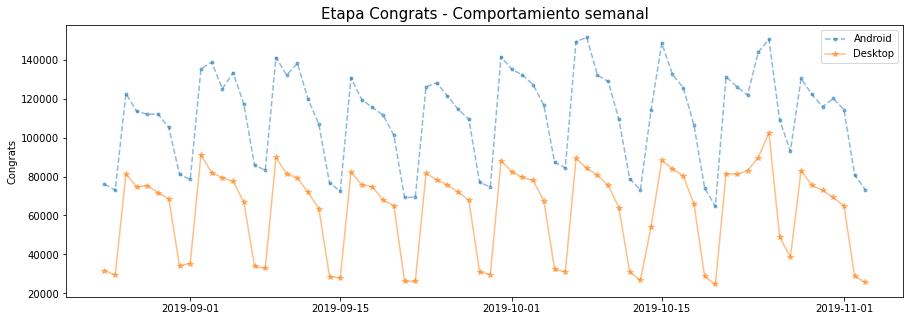

In [20]:
#Analizamos por separado cada device durante 10 semanas.
plt.plot(df_traffic_android['2019-08-24':'2019-11-03']["Congrats"], marker='.', alpha=0.5, linestyle='dashed', label='Android')
plt.plot(df_traffic_desktop['2019-08-24':'2019-11-03']["Congrats"], marker='*', alpha=0.5, linestyle='solid', label='Desktop')

plt.ylabel('Congrats')
plt.title('Etapa Congrats - Comportamiento semanal', size=15)
plt.legend()

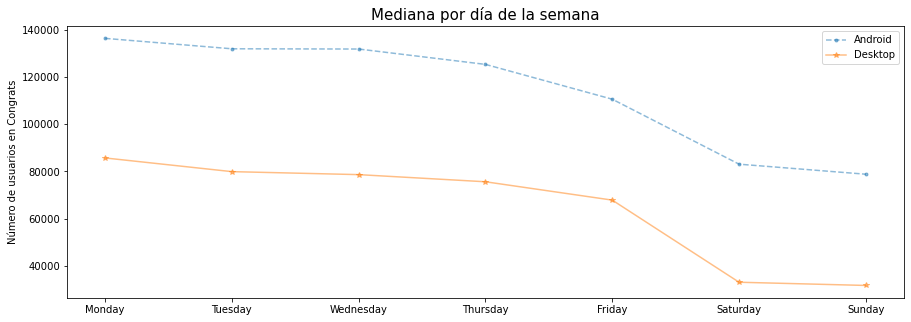

In [21]:
#Como verificación final, calculamos la mediana en función del dia semanal de la etapa Congrats 
#a lo largo de todo el dataset.
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.plot(df_traffic_android.groupby(["Weekday"])["Congrats"].median().reindex(day_order),  marker='.', alpha=0.5, linestyle='dashed', label='Android')
plt.plot(df_traffic_desktop.groupby(["Weekday"])["Congrats"].median().reindex(day_order), marker='*', alpha=0.5, linestyle='solid', label='Desktop')

plt.ylabel('Número de usuarios en Congrats')
plt.title('Mediana por día de la semana', size=15)
plt.legend()


Para poder trabajar con las series, se procederá a imputar los datos faltantes y los valores nulos de las etapas de compra en cada device por separado.

Para ello, se trabajará con la mediana del mes inmediato anterior a la fecha en la que se dan estos valores, considerando el día semanal a imputar. Esto es así dado que el comportamiento de los usuarios tiene variación según el día de la semana que se trate y considerar los valores del fin de semana alteraría sustancialmente nuestro resultado. 

In [22]:
df_traffic[cols_etapas].isnull().groupby(df_traffic.Device).sum()

Shipping  Payments  Review  Congrats
Device                                       
Android         3         2       4         2
Desktop         2         3       3         3

#### ***Imputación en Android***

In [23]:
#Identificamos los valores que hay que imputar de la columna "Review"
df_traffic_android[df_traffic_android['Review'].isnull()]

flow Site   Device              Loading             Shipping  \
Fecha                                                                        
2019-03-22  direct  MLA  Android           179,146.00           169,846.00   
2019-08-27  direct  MLA  Android           236,701.00           223,993.00   
2019-12-05  direct  MLA  Android                  nan                  nan   
2019-12-06  direct  MLA  Android                  nan                  nan   

                       Payments               Review             Congrats  \
Fecha                                                                       
2019-03-22           138,177.00                  nan            89,890.00   
2019-08-27           180,928.00                  nan           113,464.00   
2019-12-05                  nan                  nan                  nan   
2019-12-06                  nan                  nan                  nan   

              Shipping-Payments      Payments-Review      Review-Congrats  \
Fecha                                                                       
2019-03-22                 0.81                  nan                  nan   
2019-08-27                 0.81                  nan                  nan   
2019-12-05                  nan                  nan                  nan   
2019-12-06                  nan                  nan                  nan   

              Shipping-Congrats   Weekday     Month  Year         Months  
Fecha                                                                     
2019-03-22                 0.53    Friday     March  2019     March-2019  
2019-08-27                 0.51   Tuesday    August  2019    August-2019  
2019-12-05                  nan  Thursday  December  2019  December-2019  
2019-12-06                  nan    Friday  December  2019  December-2019

- Imputación del 22/03/2019

In [24]:
#Para realizar la imputación del 22/03/2019, calculamos la mediana de los viernes del mes anterior
df_traffic_android.loc['2019-02-21':'2019-03-21'].groupby('Weekday').median()


Loading             Shipping             Payments  \
Weekday                                                                    
Friday              171,518.00           162,948.00           131,581.00   
Monday              203,925.00           193,411.00           157,539.00   
Saturday            148,683.00           139,683.00           111,610.00   
Sunday              147,254.00           139,446.00           109,656.00   
Thursday            188,713.00           179,524.00           146,241.00   
Tuesday             199,265.00           188,937.00           152,940.00   
Wednesday           199,452.00           189,829.00           154,899.00   

                        Review             Congrats    Shipping-Payments  \
Weekday                                                                    
Friday               90,138.00            84,312.00                 0.82   
Monday              110,691.00           103,888.00                 0.81   
Saturday             72,558.00            64,830.00                 0.80   
Sunday               68,058.00            63,072.00                 0.78   
Thursday            100,958.00            94,906.00                 0.81   
Tuesday             106,077.00            99,631.00                 0.81   
Wednesday           107,623.00           101,071.00                 0.81   

               Payments-Review      Review-Congrats    Shipping-Congrats  Year  
Weekday                                                                         
Friday                    0.71                 0.94                 0.55  2019  
Monday                    0.70                 0.93                 0.53  2019  
Saturday                  0.67                 0.93                 0.49  2019  
Sunday                    0.62                 0.93                 0.45  2019  
Thursday                  0.69                 0.94                 0.53  2019  
Tuesday                   0.69                 0.93                 0.53  2019  
Wednesday                 0.69                 0.94                 0.53  2019

In [25]:
#Para imputar el valor de Review faltante, multiplicamos el valor de la etapa anterior ("Payments") del 22-03-2019 por el 
#valor de la mediana del ìndice PAYMENTS-REVIEW de los viernes del mes anterior.
df_traffic.loc['2019-03-22', 'Review'].replace(np.nan, 138177*0.71, inplace=True)

C:\Users\macuc\anaconda3\envs\ddatos21_ment_tp2\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [26]:
#Verificamos la imputación del valor
df_traffic['2019-03-22':'2019-03-22']

flow Site   Device              Loading             Shipping  \
Fecha                                                                        
2019-03-22  direct  MLA  Android           179,146.00           169,846.00   
2019-03-22  direct  MLA  Desktop           112,147.00           106,408.00   

                       Payments               Review             Congrats  \
Fecha                                                                       
2019-03-22           138,177.00            98,105.67            89,890.00   
2019-03-22            91,762.00            72,190.00            70,180.00   

              Shipping-Payments      Payments-Review      Review-Congrats  \
Fecha                                                                       
2019-03-22                 0.81                  nan                  nan   
2019-03-22                 0.86                 0.79                 0.97   

              Shipping-Congrats Weekday  Month  Year      Months  
Fecha                                                             
2019-03-22                 0.53  Friday  March  2019  March-2019  
2019-03-22                 0.66  Friday  March  2019  March-2019

- Imputación del 27/08/2019

In [27]:
#Para realizar la imputación del 27/07/2019, calculamos la mediana de los jueves del mes anterior
df_traffic_android.loc['2019-07-26':'2019-08-26'].groupby('Weekday').median()

Loading             Shipping             Payments  \
Weekday                                                                    
Friday              247,242.00           235,791.00           192,551.00   
Monday              291,227.00           275,914.00           227,354.00   
Saturday            188,366.00           178,857.00           145,080.00   
Sunday              190,801.00           180,127.00           144,757.00   
Thursday            265,038.00           252,808.50           205,737.00   
Tuesday             290,083.00           276,419.00           226,820.50   
Wednesday           278,572.00           264,752.00           216,127.50   

                        Review             Congrats    Shipping-Payments  \
Weekday                                                                    
Friday              128,237.00           118,098.00                 0.81   
Monday              154,033.00           141,138.00                 0.82   
Saturday             89,490.00            81,678.00                 0.80   
Sunday               86,767.00            78,735.00                 0.80   
Thursday            139,125.00           128,400.00                 0.81   
Tuesday             153,937.50           136,893.50                 0.82   
Wednesday           146,804.00           132,380.50                 0.81   

               Payments-Review      Review-Congrats    Shipping-Congrats  Year  
Weekday                                                                         
Friday                    0.67                 0.92                 0.50  2019  
Monday                    0.68                 0.92                 0.51  2019  
Saturday                  0.63                 0.92                 0.46  2019  
Sunday                    0.62                 0.91                 0.44  2019  
Thursday                  0.67                 0.92                 0.50  2019  
Tuesday                   0.66                 0.91                 0.48  2019  
Wednesday                 0.66                 0.92                 0.49  2019

In [28]:
#Para imputar el valor de Review faltante, multiplicamos el valor de la etapa anterior ("Payments") del 27/08/2019 por el valor de la mediana del ìndice PAYMENTS-REVIEW de los jueves del mes anterior.
df_traffic.loc['2019-08-27', 'Review'].replace(np.nan, 180928*0.67, inplace=True)

C:\Users\macuc\anaconda3\envs\ddatos21_ment_tp2\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [29]:
#Verificamos la imputación del valor

df_traffic['2019-08-27':'2019-08-27']

flow Site   Device              Loading             Shipping  \
Fecha                                                                        
2019-08-27  direct  MLA  Android           236,701.00           223,993.00   
2019-08-27  direct  MLA  Desktop           124,108.00           118,209.00   

                       Payments               Review             Congrats  \
Fecha                                                                       
2019-08-27           180,928.00           121,221.76           113,464.00   
2019-08-27           102,472.00            76,035.00            74,640.00   

              Shipping-Payments      Payments-Review      Review-Congrats  \
Fecha                                                                       
2019-08-27                 0.81                  nan                  nan   
2019-08-27                 0.87                 0.74                 0.98   

              Shipping-Congrats  Weekday   Month  Year       Months  
Fecha                                                                
2019-08-27                 0.51  Tuesday  August  2019  August-2019  
2019-08-27                 0.63  Tuesday  August  2019  August-2019

- Imputación del 07/05/2019

In [30]:
#Identificamos los valores que hay que imputar de la columna "Shipping"

df_traffic_android[df_traffic_android['Shipping'].isnull()]

flow Site   Device              Loading             Shipping  \
Fecha                                                                        
2019-05-07  direct  MLA  Android           224,056.00                  nan   
2019-12-05  direct  MLA  Android                  nan                  nan   
2019-12-06  direct  MLA  Android                  nan                  nan   

                       Payments               Review             Congrats  \
Fecha                                                                       
2019-05-07           172,472.00           121,321.00           113,250.00   
2019-12-05                  nan                  nan                  nan   
2019-12-06                  nan                  nan                  nan   

              Shipping-Payments      Payments-Review      Review-Congrats  \
Fecha                                                                       
2019-05-07                  nan                 0.70                 0.93   
2019-12-05                  nan                  nan                  nan   
2019-12-06                  nan                  nan                  nan   

              Shipping-Congrats   Weekday     Month  Year         Months  
Fecha                                                                     
2019-05-07                  nan   Tuesday       May  2019       May-2019  
2019-12-05                  nan  Thursday  December  2019  December-2019  
2019-12-06                  nan    Friday  December  2019  December-2019

In [31]:
#Para realizar la imputación del 07/05/2019, calculamos la mediana de los martes del mes anterior
df_traffic_android.loc['2019-04-06':'2019-05-06'].groupby('Weekday').median()

Loading             Shipping             Payments  \
Weekday                                                                    
Friday              182,734.00           173,590.50           141,334.00   
Monday              206,569.00           196,252.00           158,545.00   
Saturday            155,781.00           147,074.00           117,873.00   
Sunday              148,392.00           139,917.00           111,101.00   
Thursday            199,085.00           189,087.00           153,456.50   
Tuesday             196,051.50           186,314.00           150,456.00   
Wednesday           180,439.00           171,450.50           138,530.50   

                        Review             Congrats    Shipping-Payments  \
Weekday                                                                    
Friday               97,355.50            91,276.50                 0.81   
Monday              111,547.00           104,517.00                 0.81   
Saturday             76,041.00            70,248.00                 0.80   
Sunday               69,483.00            64,134.00                 0.79   
Thursday            104,948.50            98,285.00                 0.81   
Tuesday             102,833.50            95,549.00                 0.81   
Wednesday            93,849.00            87,638.00                 0.81   

               Payments-Review      Review-Congrats    Shipping-Congrats  Year  
Weekday                                                                         
Friday                    0.69                 0.94                 0.52  2019  
Monday                    0.70                 0.94                 0.53  2019  
Saturday                  0.65                 0.93                 0.49  2019  
Sunday                    0.63                 0.92                 0.46  2019  
Thursday                  0.68                 0.94                 0.52  2019  
Tuesday                   0.68                 0.93                 0.51  2019  
Wednesday                 0.68                 0.93                 0.51  2019

In [32]:
#Para imputar el valor de Shipping faltante, dividimos el valor de la etapa posterior ("Payments") 
#del  07/05/2019 por el valor de la mediana del ìndice SHIPPING-PAYMENTS de los Martes del mes 
#anterior.

df_traffic.loc['2019-05-07', 'Shipping'].replace(np.nan, 172472//0.81, inplace=True) 

C:\Users\macuc\anaconda3\envs\ddatos21_ment_tp2\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [33]:
#Verificamos la imputación del valor

df_traffic.loc[df_traffic.index=='2019-05-07']

flow Site   Device              Loading             Shipping  \
Fecha                                                                        
2019-05-07  direct  MLA  Android           224,056.00           212,928.00   
2019-05-07  direct  MLA  Desktop           130,456.00           123,859.00   

                       Payments               Review             Congrats  \
Fecha                                                                       
2019-05-07           172,472.00           121,321.00           113,250.00   
2019-05-07           106,000.00            82,679.00            80,191.00   

              Shipping-Payments      Payments-Review      Review-Congrats  \
Fecha                                                                       
2019-05-07                  nan                 0.70                 0.93   
2019-05-07                 0.86                 0.78                 0.97   

              Shipping-Congrats  Weekday Month  Year    Months  
Fecha                                                           
2019-05-07                  nan  Tuesday   May  2019  May-2019  
2019-05-07                 0.65  Tuesday   May  2019  May-2019

#### ***IMPUTACIÓN PRIMERA SEMANA DICIEMBRE 2019***
#### ***Imputación en Android***

In [34]:
#Identificamos los valores que hay que imputar de la columna "Review"

df_traffic[df_traffic['Review'].isnull()]

flow Site   Device              Loading             Shipping  \
Fecha                                                                        
2019-12-04  direct  MLA  Desktop           146,932.00           138,124.00   
2019-12-05  direct  MLA  Android                  nan                  nan   
2019-12-05  direct  MLA  Desktop                  nan                  nan   
2019-12-06  direct  MLA  Android                  nan                  nan   
2019-12-06  direct  MLA  Desktop                  nan                  nan   

                       Payments               Review             Congrats  \
Fecha                                                                       
2019-12-04                  nan                  nan                  nan   
2019-12-05                  nan                  nan                  nan   
2019-12-05                  nan                  nan                  nan   
2019-12-06                  nan                  nan                  nan   
2019-12-06                  nan                  nan                  nan   

              Shipping-Payments      Payments-Review      Review-Congrats  \
Fecha                                                                       
2019-12-04                 0.03                 0.68                 0.98   
2019-12-05                  nan                  nan                  nan   
2019-12-05                  nan                  nan                  nan   
2019-12-06                  nan                  nan                  nan   
2019-12-06                  nan                  nan                  nan   

              Shipping-Congrats    Weekday     Month  Year         Months  
Fecha                                                                      
2019-12-04                 0.02  Wednesday  December  2019  December-2019  
2019-12-05                  nan   Thursday  December  2019  December-2019  
2019-12-05                  nan   Thursday  December  2019  December-2019  
2019-12-06                  nan     Friday  December  2019  December-2019  
2019-12-06                  nan     Friday  December  2019  December-2019

In [35]:
#Analizamos en el dataset de Android la mediana del mes anterior a la semana del 5 y 6 de Diciembre
#según el día semanal
df_traffic_android.loc['2019-11-01':'2019-12-03'].groupby('Weekday').median()

Loading             Shipping             Payments  \
Weekday                                                                    
Friday              226,481.00           216,858.00           177,255.00   
Monday              337,325.00           323,006.00           266,756.00   
Saturday            176,252.00           167,844.00           134,290.00   
Sunday              177,604.00           170,996.00           132,739.00   
Thursday            252,376.00           242,040.00           194,563.00   
Tuesday             272,491.00           258,546.00           209,185.00   
Wednesday           256,058.50           245,658.00           199,245.50   

                        Review             Congrats    Shipping-Payments  \
Weekday                                                                    
Friday              124,110.00           114,309.00                 0.81   
Monday              175,986.00           160,983.00                 0.80   
Saturday             87,206.00            80,820.00                 0.79   
Sunday               81,824.00            74,368.00                 0.78   
Thursday            129,871.50           118,687.00                 0.80   
Tuesday             145,548.00           133,983.00                 0.81   
Wednesday           135,483.00           123,901.50                 0.81   

               Payments-Review      Review-Congrats    Shipping-Congrats  Year  
Weekday                                                                         
Friday                    0.67                 0.92                 0.50  2019  
Monday                    0.65                 0.91                 0.47  2019  
Saturday                  0.64                 0.92                 0.46  2019  
Sunday                    0.62                 0.90                 0.44  2019  
Thursday                  0.66                 0.91                 0.48  2019  
Tuesday                   0.67                 0.91                 0.49  2019  
Wednesday                 0.67                 0.91                 0.50  2019

In [36]:
#Imputamos de manera directa cada valor faltante por la mediana particular en función de los valores 
#correspondientes al día Jueves. 
df_traffic.loc[(df_traffic['Device']=="Android") & (df_traffic.index=='2019-12-05'), 'Loading'] = 252376

df_traffic.loc[(df_traffic['Device']=="Android") & (df_traffic.index=='2019-12-05'), 'Shipping'] = 242040

df_traffic.loc[(df_traffic['Device']=="Android") & (df_traffic.index=='2019-12-05'), 'Payments'] = 194563

df_traffic.loc[(df_traffic['Device']=="Android") & (df_traffic.index=='2019-12-05'), 'Review'] = 129871

df_traffic.loc[(df_traffic['Device']=="Android") & (df_traffic.index=='2019-12-05'), 'Congrats'] = 118687

In [37]:
#Imputamos de manera directa cada valor faltante por la mediana particular en función de los valores 
#correspondientes al día Viernes 

df_traffic.loc[(df_traffic['Device']=="Android") & (df_traffic.index=='2019-12-06'), 'Loading'] = 226481

df_traffic.loc[(df_traffic['Device']=="Android") & (df_traffic.index=='2019-12-06'), 'Shipping'] =216858

df_traffic.loc[(df_traffic['Device']=="Android") & (df_traffic.index=='2019-12-06'), 'Payments'] = 177255

df_traffic.loc[(df_traffic['Device']=="Android") & (df_traffic.index=='2019-12-06'), 'Review'] = 124110

df_traffic.loc[(df_traffic['Device']=="Android") & (df_traffic.index=='2019-12-06'), 'Congrats'] = 114309

#### ***Imputación en Desktop***

In [38]:
#Analizamos en el data set de Desktop la mediana del mes anterior a la semana del 4, 5 y 6 de 
#diciembre según el día semanal
df_traffic_desktop.loc['2019-11-01':'2019-12-03'].groupby('Weekday').median()

Loading             Shipping             Payments  \
Weekday                                                                    
Friday              108,648.00           101,930.00            86,767.00   
Monday              150,301.00           141,573.00           121,093.00   
Saturday             52,243.00            48,816.00            40,903.00   
Sunday               48,978.00            45,426.00            37,222.00   
Thursday            117,014.00           110,404.50            93,722.00   
Tuesday             133,687.00           125,652.00           107,123.00   
Wednesday           122,951.00           115,670.50            98,365.00   

                        Review             Congrats    Shipping-Payments  \
Weekday                                                                    
Friday               67,833.00            66,191.00                 0.85   
Monday               94,276.00            91,933.00                 0.85   
Saturday             30,022.00            29,232.00                 0.84   
Sunday               27,217.00            26,724.00                 0.83   
Thursday             72,371.50            69,970.00                 0.85   
Tuesday              83,293.00            80,926.00                 0.85   
Wednesday            76,553.00            74,750.00                 0.85   

               Payments-Review      Review-Congrats    Shipping-Congrats  Year  
Weekday                                                                         
Friday                    0.78                 0.98                 0.65  2019  
Monday                    0.78                 0.97                 0.64  2019  
Saturday                  0.72                 0.97                 0.59  2019  
Sunday                    0.73                 0.97                 0.59  2019  
Thursday                  0.77                 0.97                 0.62  2019  
Tuesday                   0.78                 0.97                 0.64  2019  
Wednesday                 0.78                 0.98                 0.64  2019

In [39]:
#Para imputar el valor de cada etapa faltante, multiplicamos el valor de la etapa anterior del 
#04/12/2019 por el valor de la mediana del ìndice correspondiente a los miércoles del mes anterior.

df_traffic.loc['2019-12-04', 'Payments'].replace(np.nan, 138124*0.85, inplace=True)
df_traffic.loc['2019-12-04', 'Review'].replace(np.nan, 138124*0.85*0.78, inplace=True)
df_traffic.loc['2019-12-04', 'Congrats'].replace(np.nan, 138124*0.85*0.78*0.98, inplace=True)

C:\Users\macuc\anaconda3\envs\ddatos21_ment_tp2\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [40]:
df_traffic_desktop.loc['2019-11-01':'2019-12-03'].groupby('Weekday').median()

Loading             Shipping             Payments  \
Weekday                                                                    
Friday              108,648.00           101,930.00            86,767.00   
Monday              150,301.00           141,573.00           121,093.00   
Saturday             52,243.00            48,816.00            40,903.00   
Sunday               48,978.00            45,426.00            37,222.00   
Thursday            117,014.00           110,404.50            93,722.00   
Tuesday             133,687.00           125,652.00           107,123.00   
Wednesday           122,951.00           115,670.50            98,365.00   

                        Review             Congrats    Shipping-Payments  \
Weekday                                                                    
Friday               67,833.00            66,191.00                 0.85   
Monday               94,276.00            91,933.00                 0.85   
Saturday             30,022.00            29,232.00                 0.84   
Sunday               27,217.00            26,724.00                 0.83   
Thursday             72,371.50            69,970.00                 0.85   
Tuesday              83,293.00            80,926.00                 0.85   
Wednesday            76,553.00            74,750.00                 0.85   

               Payments-Review      Review-Congrats    Shipping-Congrats  Year  
Weekday                                                                         
Friday                    0.78                 0.98                 0.65  2019  
Monday                    0.78                 0.97                 0.64  2019  
Saturday                  0.72                 0.97                 0.59  2019  
Sunday                    0.73                 0.97                 0.59  2019  
Thursday                  0.77                 0.97                 0.62  2019  
Tuesday                   0.78                 0.97                 0.64  2019  
Wednesday                 0.78                 0.98                 0.64  2019

In [41]:
df_traffic.loc[(df_traffic['Device']=="Desktop") & (df_traffic.index=='2019-12-05'), 'Loading'] = 117014

df_traffic.loc[(df_traffic['Device']=="Desktop") & (df_traffic.index=='2019-12-05'), 'Shipping'] = 110404

df_traffic.loc[(df_traffic['Device']=="Desktop") & (df_traffic.index=='2019-12-05'), 'Payments'] = 93722

df_traffic.loc[(df_traffic['Device']=="Desktop") & (df_traffic.index=='2019-12-05'), 'Review'] = 72371

df_traffic.loc[(df_traffic['Device']=="Desktop") & (df_traffic.index=='2019-12-05'), 'Congrats'] = 69970


In [42]:
df_traffic.loc[(df_traffic['Device']=="Desktop") & (df_traffic.index=='2019-12-06'), 'Loading'] = 108649

df_traffic.loc[(df_traffic['Device']=="Desktop") & (df_traffic.index=='2019-12-06'), 'Shipping'] = 101930

df_traffic.loc[(df_traffic['Device']=="Desktop") & (df_traffic.index=='2019-12-06'), 'Payments'] = 86767

df_traffic.loc[(df_traffic['Device']=="Desktop") & (df_traffic.index=='2019-12-06'), 'Review'] = 67833

df_traffic.loc[(df_traffic['Device']=="Desktop") & (df_traffic.index=='2019-12-06'), 'Congrats'] = 66191

In [43]:
df_traffic.loc['2019-12-05':'2019-12-06']

flow Site   Device              Loading             Shipping  \
Fecha                                                                        
2019-12-05  direct  MLA  Android           252,376.00           242,040.00   
2019-12-05  direct  MLA  Desktop           117,014.00           110,404.00   
2019-12-06  direct  MLA  Android           226,481.00           216,858.00   
2019-12-06  direct  MLA  Desktop           108,649.00           101,930.00   

                       Payments               Review             Congrats  \
Fecha                                                                       
2019-12-05           194,563.00           129,871.00           118,687.00   
2019-12-05            93,722.00            72,371.00            69,970.00   
2019-12-06           177,255.00           124,110.00           114,309.00   
2019-12-06            86,767.00            67,833.00            66,191.00   

              Shipping-Payments      Payments-Review      Review-Congrats  \
Fecha                                                                       
2019-12-05                  nan                  nan                  nan   
2019-12-05                  nan                  nan                  nan   
2019-12-06                  nan                  nan                  nan   
2019-12-06                  nan                  nan                  nan   

              Shipping-Congrats   Weekday     Month  Year         Months  
Fecha                                                                     
2019-12-05                  nan  Thursday  December  2019  December-2019  
2019-12-05                  nan  Thursday  December  2019  December-2019  
2019-12-06                  nan    Friday  December  2019  December-2019  
2019-12-06                  nan    Friday  December  2019  December-2019

### ***Chequeo de valores nulos***

In [44]:
#Localizamos los datos faltantes en el dataset original
df_traffic[df_traffic['Shipping'].isnull()|df_traffic['Review'].isnull()]

Empty DataFrame
Columns: [flow, Site, Device, Loading, Shipping, Payments, Review, Congrats, Shipping-Payments, Payments-Review, Review-Congrats, Shipping-Congrats, Weekday, Month, Year, Months]
Index: []

Podemos observar que ya no quedaron valores nulos en el dataset. 

### ***7- RECÁLCULO DE LOS ÍNDICES***

In [45]:
#Recalculamos las columnas de indice
df_traffic["Shipping-Payments"] = df_traffic["Payments"] / df_traffic["Shipping"]
df_traffic["Payments-Review"] = df_traffic["Review"] / df_traffic["Payments"]
df_traffic["Review-Congrats"] = df_traffic["Congrats"] / df_traffic["Review"]
df_traffic["Shipping-Congrats"] = df_traffic["Congrats"] / df_traffic["Shipping"]

#agrupamos las columnas de índices para evaluar su comportamiento por separado de las etapas
cols_indices = ['Shipping-Payments', 'Payments-Review', 'Review-Congrats', 'Shipping-Congrats']



In [46]:
#Buscamos en el dataset observaciones que no cumplan con la lógica del funnel, 
#que presenten en una etapa previa menos observaciones que en una posterior para verificar 
#si la imputación resultó lógica.
columns = df_traffic.columns.tolist()
columns
df_traffic_sospechoso = df_traffic[(df_traffic[cols_indices].iloc[:,:] > 1).any(axis=1)]
df_traffic_sospechoso

Empty DataFrame
Columns: [flow, Site, Device, Loading, Shipping, Payments, Review, Congrats, Shipping-Payments, Payments-Review, Review-Congrats, Shipping-Congrats, Weekday, Month, Year, Months]
Index: []

Luego de la imputación no hay valores sospechosos que rompan la lógica del dropout entre etapas.

Text(0.5, 1.0, 'Etapas')

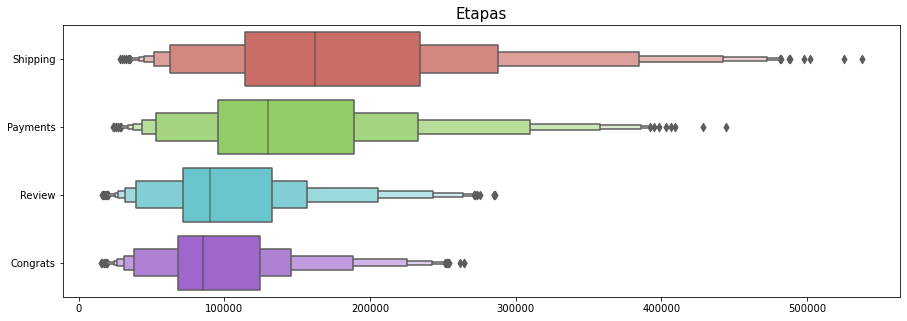

In [47]:
#Analizamos con un boxenplot si luego de la imputación existen nuevos outliers.
plt.rcParams['figure.figsize'] = (15, 5)
sns.boxenplot(data=df_traffic[cols_etapas], orient = "h", palette='hls')
plt.title('Etapas', size=15)

Vemos que los outliers detectados anteriormente han desaparecido y no se generaron nuevos valores outliers.

### ***8- TRANSFORMACIÓN LOGARÍTMICA***

Teniendo nuestro data set "limpio", con los valores nulos y faltantes correctamente imputados, vamos a volver a nuestro procesamiento para sustraer el comportamiento semanal detectado y la tendencia luego del comienzo del confinamiento por la  pandemia el cual ya hemos mostrado anteriormente.

In [48]:
#Agregamos una columna donde guardamos los valores transformados logarítmicamente
cols_etapas_log=['Shipping_log', 'Payments_log', 'Review_log', 'Congrats_log']
cols_etapas_total = cols_etapas + cols_etapas_log


In [49]:
#Realizamos la transformación de las etapas
df_traffic[cols_etapas_log] = np.log(df_traffic[cols_etapas])

# volvemos a definir los dos datasets de interes con las nuevas columnas
df_traffic_desktop = df_traffic[df_traffic.Device==("Desktop")]
df_traffic_android = df_traffic[df_traffic.Device==("Android")]

In [50]:
df_traffic[cols_etapas_total].describe()

Shipping             Payments               Review  \
count               976.00               976.00               976.00   
mean            181,517.77           148,502.27           103,705.01   
std             102,255.30            82,071.82            54,141.03   
min              28,722.00            23,918.00            15,901.00   
25%             114,274.75            96,055.25            71,492.50   
50%             162,349.00           130,287.50            90,329.50   
75%             234,312.50           189,188.00           132,908.75   
max             537,723.00           444,330.00           286,162.00   

                  Congrats         Shipping_log         Payments_log  \
count               976.00               976.00               976.00   
mean             97,265.29                11.94                11.75   
std              49,282.51                 0.60                 0.59   
min              15,418.00                10.27                10.08   
25%              68,589.25                11.65                11.47   
50%              85,137.50                12.00                11.78   
75%             124,617.50                12.36                12.15   
max             264,742.00                13.20                13.00   

                Review_log         Congrats_log  
count               976.00               976.00  
mean                 11.41                11.35  
std                   0.56                 0.55  
min                   9.67                 9.64  
25%                  11.18                11.14  
50%                  11.41                11.35  
75%                  11.80                11.73  
max                  12.56                12.49

Podemos observar de manera puntual el efecto de la transformación a través de las medidas estadísticas descriptivas. Sin embargo, debemos analizar el efecto en el comportamiento temporal de las etapas para verificar su eficacia.

In [51]:
#Nuevamente, graficamos una etapa en particular transformada logarítmicamente tanto de Android como Desktop. Podemos ver tanto la tendencia como el comportamiento semanal se mantienen. 
fig3 = px.line(df_traffic, x= df_traffic.index , y= 'Congrats_log', color='Device').update_layout(yaxis_title="Número de usuarios en CONGRATS",  title={
        'text': "CONGRATS Tranf. log",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig3.update_xaxes(rangeslider_visible=True)
fig3.show()


In [52]:
ambas_congrats = ['Congrats','Congrats_log']

In [53]:
# Para visualizar el efecto de la transformación, graficamos en un mismo eje una de las etapas 
#(Congrats) a partir de los datos originales y los datos transformados. 
fig7 = px.line(df_traffic_desktop, x= df_traffic_desktop.index , y= ambas_congrats).update_layout(yaxis_title="Transacciones en Congrats y log_congrats", 
        title={
        'text': "CONGRATS EN DESKTOP",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig7.update_xaxes(rangeslider_visible=True)


fig7.show()

In [54]:
#Para poder verificar el comportamiento de la variable tanto original como transformada 
#logaritmicamente, los graficamos en dos ejes.
from plotly.subplots import make_subplots

subfig = make_subplots(specs=[[{"secondary_y": True}]])

fig = px.line(df_traffic_desktop, x= df_traffic_desktop.index , y= 'Congrats')
fig2 = px.line(df_traffic_desktop, x= df_traffic_desktop.index , y= 'Congrats_log')

fig2.update_traces(yaxis="y2")

subfig.add_traces(fig.data + fig2.data)
subfig.layout.xaxis.title="Time"
subfig.layout.yaxis.title="Congrats"
subfig.layout.yaxis2.title="Log Congrats"

subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.for_each_trace(lambda t: t.update(textfont_color=t.marker.color, textposition='top center'))

subfig.update_xaxes(rangeslider_visible=True)

subfig.show()

Podemos observar que el comportamiento de la etapa transformada parece estar más compactado pero no fue lo suficientemente efectivo para sustraer el comportamiento semanal y la tendencia.

# OPCIONAL 1. ACF

La autocorrelación en las series temporales se utiliza para describir la presencia o ausencia de correlación en los datos de las series temporales, indicando si las observaciones pasadas influyen en las actuales.

*La función de autocorrelación (ACF)* mide la correlación entre dos variables separadas por k periodos (lags). Mide el grado de asociación lineal que existe entre dos variables del mismo proceso estocástico.

*La función de autocorrelación parcial (PACF)* mide la correlación entre dos variables separadas por k periodos (lags) cuando no se considera la dependencia creada por los retardos intermedios existentes entre ambas. Mide la autocorrelación que existe entre dos variables separadas k períodos descontando los posibles efectos debidos a variables intermedias.

La función ACF es usada para identificar el proceso de media móvil (MA).

Los gráficos generados a partir de estas funciones se denominan correlogramas, los cuales contienen bandas con un intervalo de confianza del 95%.

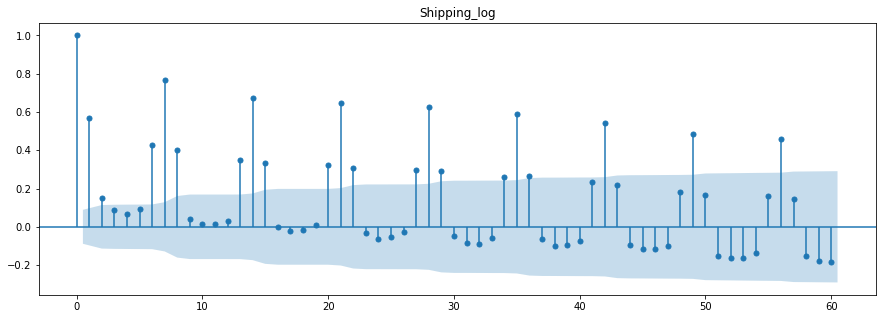

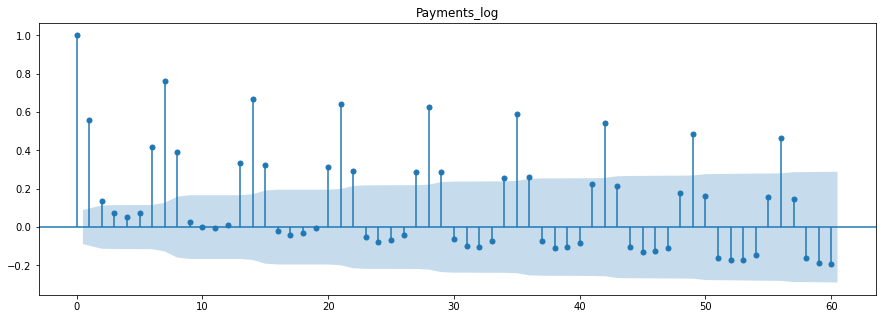

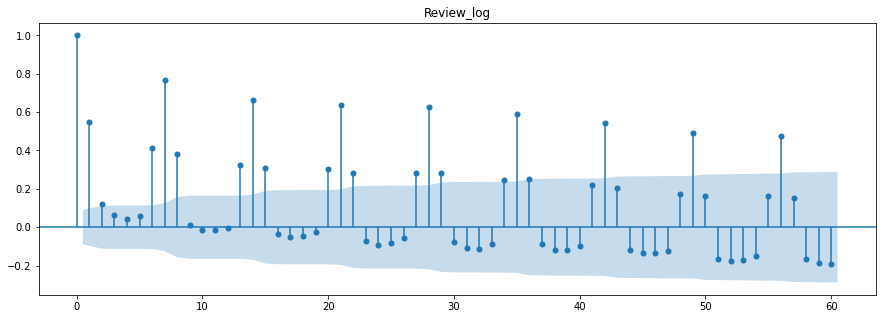

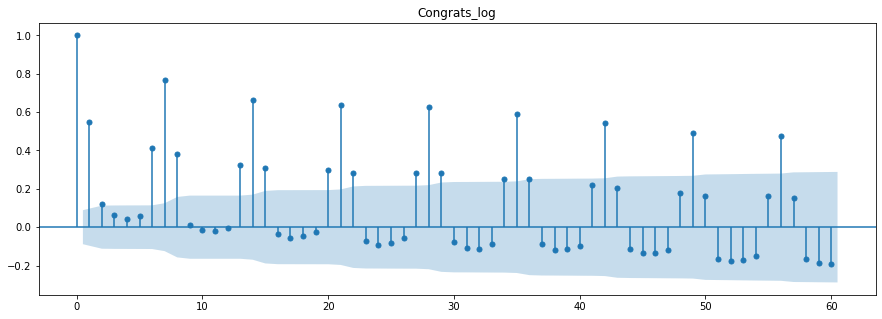

In [55]:
#A través de las funciones ACF, vamos a corroborar si habiendo hecho la transformación logarítmica 
#hemos logrado eliminar el comportamiento semanal

from statsmodels.graphics.tsaplots import plot_acf
for etapa in cols_etapas_log:
    series = df_traffic_desktop[etapa]
    plot_acf(series, title = etapa, lags=60)
    plt.show()

Los picos en ACF cada 7 lags evidencian que el comportamiento semanal se mantiene. 

# OPCIONAL 2. MEDIAS MÓVILES


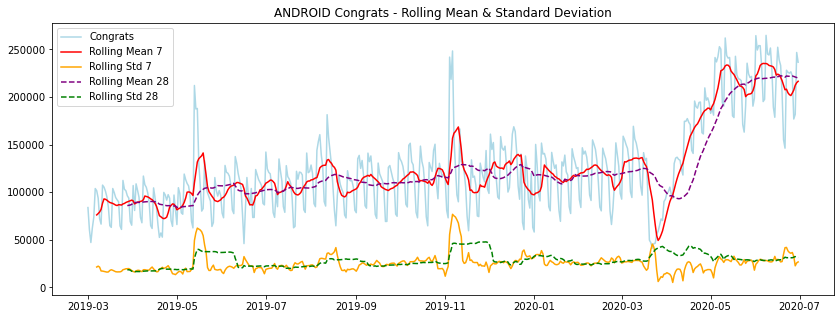

In [56]:
rolmean7 = df_traffic_android["Congrats"].rolling(window=7).mean()
rolstd7 = df_traffic_android["Congrats"].rolling(window=7).std()
rolmean28 = df_traffic_android["Congrats"].rolling(window=28).mean()
rolstd28 = df_traffic_android["Congrats"].rolling(window=28).std()    
plt.figure(figsize=(14,5))
sns.despine(left=True)
orig = plt.plot(df_traffic_android["Congrats"], color='lightblue',label='Congrats')
mean7 = plt.plot(rolmean7, color='red', label='Rolling Mean 7')
std7 = plt.plot(rolstd7, color='orange', label = 'Rolling Std 7')
mean28 = plt.plot(rolmean28, color='purple', linestyle= "dashed", label='Rolling Mean 28')
std28 = plt.plot(rolstd28, color='green', linestyle= "dashed", label = 'Rolling Std 28')
plt.legend(loc='best'); plt.title('ANDROID Congrats - Rolling Mean & Standard Deviation')
plt.show()

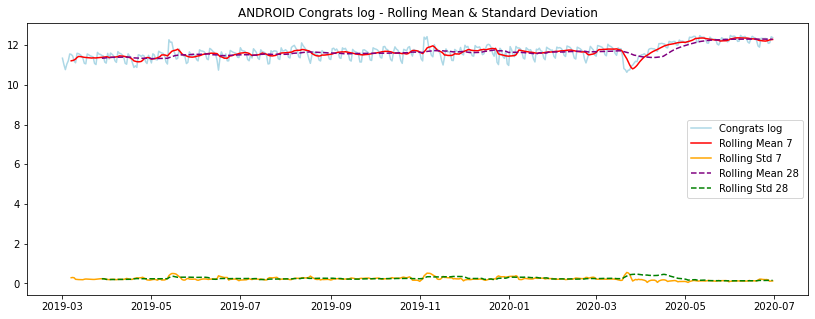

In [57]:
rolmean7 = df_traffic_android["Congrats_log"].rolling(window=7).mean()
rolstd7 = df_traffic_android["Congrats_log"].rolling(window=7).std()
rolmean28 = df_traffic_android["Congrats_log"].rolling(window=28).mean()
rolstd28 = df_traffic_android["Congrats_log"].rolling(window=28).std()    
plt.figure(figsize=(14,5))
sns.despine(left=True)
orig = plt.plot(df_traffic_android["Congrats_log"], color='lightblue',label='Congrats log')
mean7 = plt.plot(rolmean7, color='red', label='Rolling Mean 7')
std7 = plt.plot(rolstd7, color='orange', label = 'Rolling Std 7')
mean28 = plt.plot(rolmean28, color='purple', linestyle= "dashed", label='Rolling Mean 28')
std28 = plt.plot(rolstd28, color='green', linestyle= "dashed", label = 'Rolling Std 28')
plt.legend(loc='best'); plt.title('ANDROID Congrats log - Rolling Mean & Standard Deviation')
plt.show()

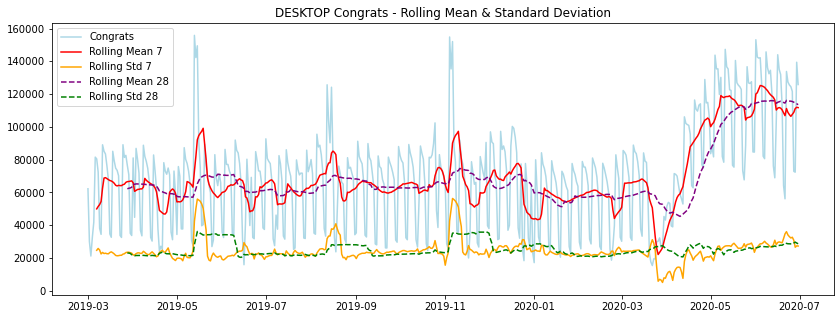

In [58]:
rolmean7 = df_traffic_desktop["Congrats"].rolling(window=7).mean()
rolstd7 = df_traffic_desktop["Congrats"].rolling(window=7).std()
rolmean28 = df_traffic_desktop["Congrats"].rolling(window=28).mean()
rolstd28 = df_traffic_desktop["Congrats"].rolling(window=28).std()    
plt.figure(figsize=(14,5))
sns.despine(left=True)
orig = plt.plot(df_traffic_desktop["Congrats"], color='lightblue',label='Congrats')
mean7 = plt.plot(rolmean7, color='red', label='Rolling Mean 7')
std7 = plt.plot(rolstd7, color='orange', label = 'Rolling Std 7')
mean28 = plt.plot(rolmean28, color='purple', linestyle= "dashed", label='Rolling Mean 28')
std28 = plt.plot(rolstd28, color='green', linestyle= "dashed", label = 'Rolling Std 28')
plt.legend(loc='best'); plt.title('DESKTOP Congrats - Rolling Mean & Standard Deviation')
plt.show()

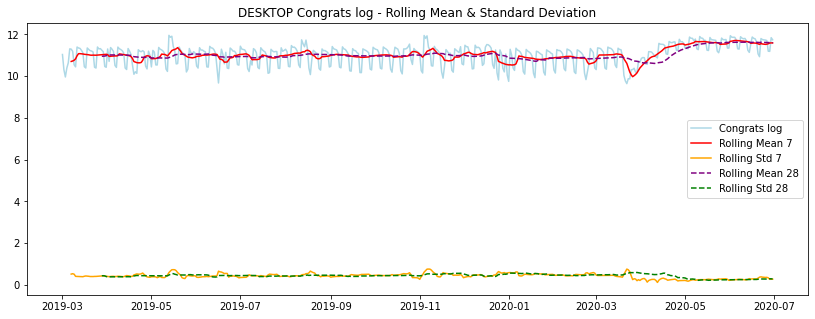

In [59]:
rolmean7 = df_traffic_desktop["Congrats_log"].rolling(window=7).mean()
rolstd7 = df_traffic_desktop["Congrats_log"].rolling(window=7).std()
rolmean28 = df_traffic_desktop["Congrats_log"].rolling(window=28).mean()
rolstd28 = df_traffic_desktop["Congrats_log"].rolling(window=28).std()    
plt.figure(figsize=(14,5))
sns.despine(left=True)
orig = plt.plot(df_traffic_desktop["Congrats_log"], color='lightblue',label='Congrats log')
mean7 = plt.plot(rolmean7, color='red', label='Rolling Mean 7')
std7 = plt.plot(rolstd7, color='orange', label = 'Rolling Std 7')
mean28 = plt.plot(rolmean28, color='purple', linestyle= "dashed", label='Rolling Mean 28')
std28 = plt.plot(rolstd28, color='green', linestyle= "dashed", label = 'Rolling Std 28')
plt.legend(loc='best'); plt.title('DESKTOP Congrats log - Rolling Mean & Standard Deviation')
plt.show()

Entiendo que la ciclicidad se muestra cada 7 lags, podemos intuir que también debería existir un patrón cada 28 días, es decir, mensualmente. El cálculo de medias móviles para 7 lags, si bien suaviza la serie, no elimina los picos de la serie ni la tendencia. Si se calculan las medias móviles para 28 lags, sucede lo mismo. La suavización de la serie es incluso mayor pero la tendencia y la ciclicidad de la serie sigue siendo evidente. 

***ANALISIS DE SERIE ESTACIONARIA***


Tomaremos como referencia la columna de Congrats del Device Android para verificar que se trata de una serie no estacionaria y evaluar las opciones de conseguir una serie estacionaria para luego hacer los modelos de aprendizaje automático.

The most commonly used is the **ADF** test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, id the P-Value in ADH test is less than the significance level **(0.05)**, you reject the null hypothesis.
Besides, when the test statistic is lower than the critical value shown, you reject the null hypothesis and infer that the time series is stationary. 


Links: https://www.machinelearningplus.com/time-series/time-series-analysis-python/ & https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

In [135]:
print ('<Results of Dickey-Fuller Test>')
dftest = adfuller(df_traffic_android["Congrats"], autolag='AIC')
dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

<Results of Dickey-Fuller Test>
Test Statistic                               -0.90
p-value                                       0.79
#Lags Used                                   18.00
Number of Observations Used                 469.00
Critical Value (1%)                          -3.44
Critical Value (5%)                          -2.87
Critical Value (10%)                         -2.57
dtype: float64


En nuestro caso, el estadístico es mayor a todos los intervalos de confiaza de los valores críticos y el p-valor es mayor a  0.05 por lo que no podemos rechazar la hipotesis nula de que nuestra serie es no estacionaria.

**KPSS** is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

In [134]:
result = kpss(df_traffic_android["Congrats"].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 1.470006
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\macuc\anaconda3\envs\ddatos21_ment_tp2\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

C:\Users\macuc\anaconda3\envs\ddatos21_ment_tp2\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Test for stationarity: If the test statistic is greater than the critical value, we reject the null hypothesis (series is not trend stationary). If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is trend stationary). 
En nuestro caso, el valor del estadístico es mayor que el valor crítico en todos los intervalos de confianza, por lo que confirmamos que la serie es no estacionaria. 

**Descomposición de la serie temporal de android**

In [131]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_traffic_android["Congrats"], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df_traffic_android["Congrats"], model='additive', extrapolate_trend='freq')

# Plot
#plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
#result_add.plot().suptitle('Additive Decompose', fontsize=22)
#plt.show()

Para evaluar si se trata de una serie multiplicativa o aditiva, analizamos el comportamiento de los diferentes componentes

In [132]:
# Extraemos los componentes multiplicativos
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

seas                trend                resid  \
Fecha                                                                       
2019-03-01                 1.01            64,983.59                 1.28   
2019-03-02                 0.77            68,172.11                 1.15   
2019-03-03                 0.73            71,360.63                 0.91   
2019-03-04                 1.17            76,132.43                 0.70   
2019-03-05                 1.12            77,555.29                 0.85   

                  actual_values  
Fecha                            
2019-03-01            83,856.00  
2019-03-02            60,631.00  
2019-03-03            47,156.00  
2019-03-04            62,339.00  
2019-03-05            73,578.00

Para evaluar si se trata de una serie multiplicativa, tomamos el primer caso, y multiplicamos los tres componentes (1.01*64983.59*1.28) y evaluamos si es igual al "actual value" (83856). De la multiplicación, obtenemos un valor igual a 84010.78 identificando que NO se trata de una serie multiplicativa.
Para confirmar, tomamos el segundo caso donde la multiplicación da igual a 60366.40341 siendo diferente a 60631

In [133]:
# Extraemos los componentes aditivos

df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

seas                trend                resid  \
Fecha                                                                       
2019-03-01               446.18            64,983.59            18,426.23   
2019-03-02           -27,720.56            68,172.11            20,179.45   
2019-03-03           -33,181.58            71,360.63             8,976.94   
2019-03-04            21,237.57            76,132.43           -35,031.00   
2019-03-05            14,837.10            77,555.29           -18,814.39   

                  actual_values  
Fecha                            
2019-03-01            83,856.00  
2019-03-02            60,631.00  
2019-03-03            47,156.00  
2019-03-04            62,339.00  
2019-03-05            73,578.00

Sabiendo que la serie no es multiplicativa, confirmamos que es ADITIVA.
Para esto, tomamos el primer caso, y sumamos los tres componentes (446.18+64983.59+18426.23) y evaluamos si es igual al "actual value" (83856). De la suma, obtenemos un valor igual a 83856, igual al actual value.
Para confirmar, tomamos el segundo caso donde la suma da igual a 60361 siendo igual a 60631.

Sabiendo esto, para lograr una serie estacionaria tendremos que sacarle el componente de tendencia y de estacionanalidad.

<ipython-input-114-34511cf96297>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[]

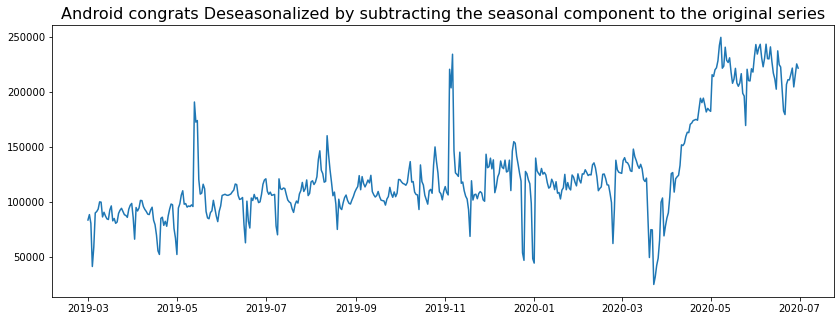

In [114]:
# Subtracting the Seasonal Component.

# Deseasonalize
df_traffic_android["Congrats_deseas"] = df_traffic_android["Congrats"].values - result_add.seasonal

# Plot
plt.figure(figsize=(14,5))

plt.plot(df_traffic_android["Congrats_deseas"])
plt.title('Android congrats Deseasonalized by subtracting the seasonal component to the original series', fontsize=16)
plt.plot()

<ipython-input-63-689113dc9f75>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Android congrats detrended by subtracting the trend component')

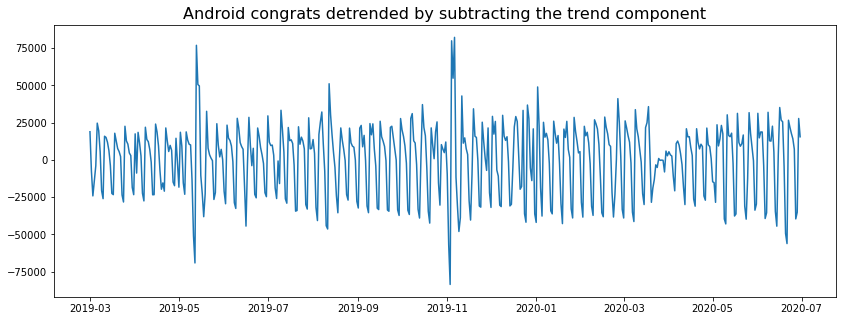

In [63]:
# Restamos el componente de tendencia.
from statsmodels.tsa.seasonal import seasonal_decompose

df_traffic_android["Congrats_detrend"] = df_traffic_android["Congrats"].values - result_add.trend
plt.figure(figsize=(14,5))
plt.plot(df_traffic_android["Congrats_detrend"])
plt.title('Android congrats detrended by subtracting the trend component', fontsize=16)

<ipython-input-116-bb9881856e9a>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[]

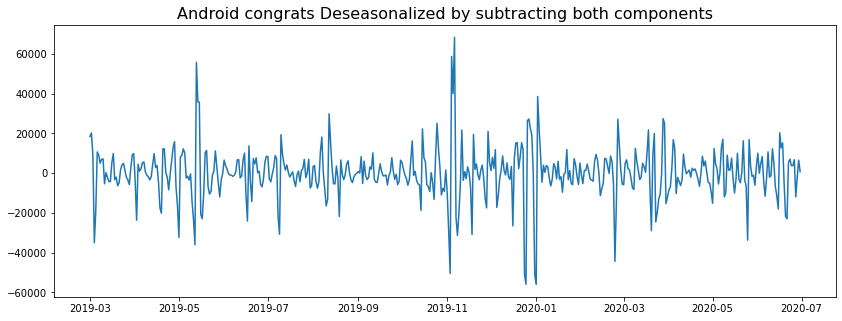

In [116]:
# RESTAMOS AMBOS COMPONENTES (SEASON Y TREND)
df_traffic_android["Congrats_stat"] = df_traffic_android["Congrats"].values - result_add.seasonal- result_add.trend

# Plot
plt.figure(figsize=(14,5))

plt.plot(df_traffic_android["Congrats_stat"])
plt.title('Android congrats Deseasonalized by subtracting both components', fontsize=16)
plt.plot()

In [67]:
from statsmodels.tsa.stattools import adfuller, kpss

print ('<Results of Dickey-Fuller Test>')
dftest = adfuller(df_traffic_android["Congrats_deseas"], autolag='AIC')
dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

<Results of Dickey-Fuller Test>
Test Statistic                               -1.80
p-value                                       0.38
#Lags Used                                    5.00
Number of Observations Used                 482.00
Critical Value (1%)                          -3.44
Critical Value (5%)                          -2.87
Critical Value (10%)                         -2.57
dtype: float64


In [70]:
print ('<Results of Dickey-Fuller Test>')
dftest = adfuller(df_traffic_android["Congrats_detrend"], autolag='AIC')
dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

<Results of Dickey-Fuller Test>
Test Statistic                               -9.57
p-value                                       0.00
#Lags Used                                   18.00
Number of Observations Used                 469.00
Critical Value (1%)                          -3.44
Critical Value (5%)                          -2.87
Critical Value (10%)                         -2.57
dtype: float64


In [69]:
print ('<Results of Dickey-Fuller Test>')
dftest = adfuller(df_traffic_android["Congrats_stat"], autolag='AIC')
dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

<Results of Dickey-Fuller Test>
Test Statistic                               -9.44
p-value                                       0.00
#Lags Used                                   16.00
Number of Observations Used                 471.00
Critical Value (1%)                          -3.44
Critical Value (5%)                          -2.87
Critical Value (10%)                         -2.57
dtype: float64


Habiendo analizado el efecto de los diferentes componentes podemos decir que restando únicamente el componente de SEASON no alcanzaba para lograr una serie estacionaria, no asi en cambio para la resta del componente de trend. 

ME QUEDA LA DUDA PORQUÉ EL NÚMERO DE OBSERVACIONES ES DIFERENTE... Y QUE TANTO PUEDE AFECTAR EL NUMERO DE LAGS QUE CAMBIA EN CADA TIPO DE TRANSFORMACION

**ANDROID SHIPPING**

<ipython-input-71-6728d96320de>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[]

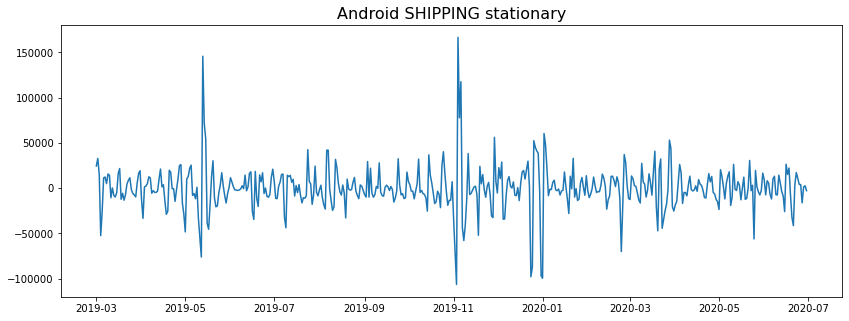

In [71]:
# Additive Decomposition
result_add = seasonal_decompose(df_traffic_android["Shipping"], model='additive', extrapolate_trend='freq')
#Detrend
df_traffic_android["Shipping_stat"] = df_traffic_android["Shipping"].values - result_add.trend- result_add.seasonal
# Plot
plt.figure(figsize=(14,5))
plt.plot(df_traffic_android["Shipping_stat"])
plt.title('Android SHIPPING stationary', fontsize=16)
plt.plot()

In [72]:
print ('<Results of Dickey-Fuller Test>')
dftest = adfuller(df_traffic_android["Shipping_stat"], autolag='AIC')
dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

<Results of Dickey-Fuller Test>
Test Statistic                               -9.51
p-value                                       0.00
#Lags Used                                   16.00
Number of Observations Used                 471.00
Critical Value (1%)                          -3.44
Critical Value (5%)                          -2.87
Critical Value (10%)                         -2.57
dtype: float64


**ANDROID PAYMENTS**

<ipython-input-73-08e1b53001f6>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[]

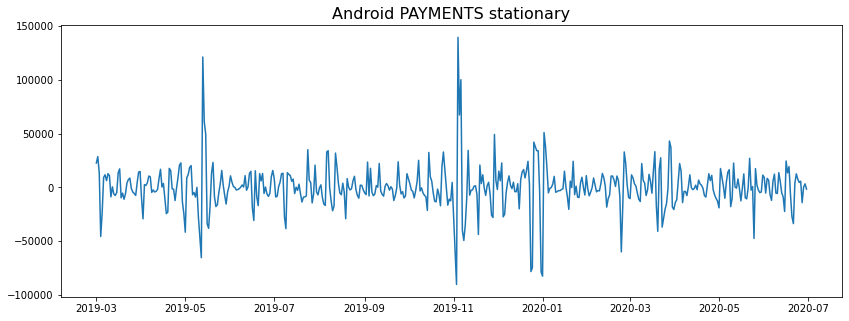

In [73]:
# Additive Decomposition
result_add = seasonal_decompose(df_traffic_android["Payments"], model='additive', extrapolate_trend='freq')
#Detrend
df_traffic_android["Payments_stat"] = df_traffic_android["Payments"].values - result_add.trend- result_add.seasonal
# Plot
plt.figure(figsize=(14,5))
plt.plot(df_traffic_android["Payments_stat"])
plt.title('Android PAYMENTS stationary', fontsize=16)
plt.plot()

**ANDROID REVIEW**

<ipython-input-74-7c29ce1fbe0d>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[]

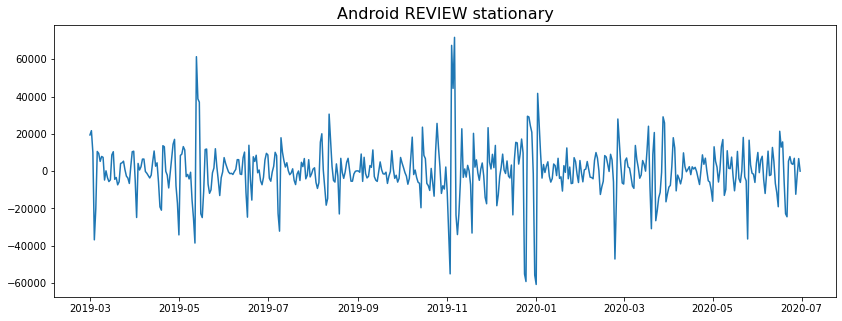

In [74]:
# Additive Decomposition
result_add = seasonal_decompose(df_traffic_android["Review"], model='additive', extrapolate_trend='freq')
#Detrend
df_traffic_android["Review_stat"] = df_traffic_android["Review"].values - result_add.trend- result_add.seasonal
# Plot
plt.figure(figsize=(14,5))
plt.plot(df_traffic_android["Review_stat"])
plt.title('Android REVIEW stationary', fontsize=16)
plt.plot()

In [75]:
#definimos las estapas estacionarias
cols_etapas_stat = ['Shipping_stat', 'Payments_stat', 'Review_stat', 'Congrats_stat']

DESCOMPOSICION DE SERIE DE DESKTOP

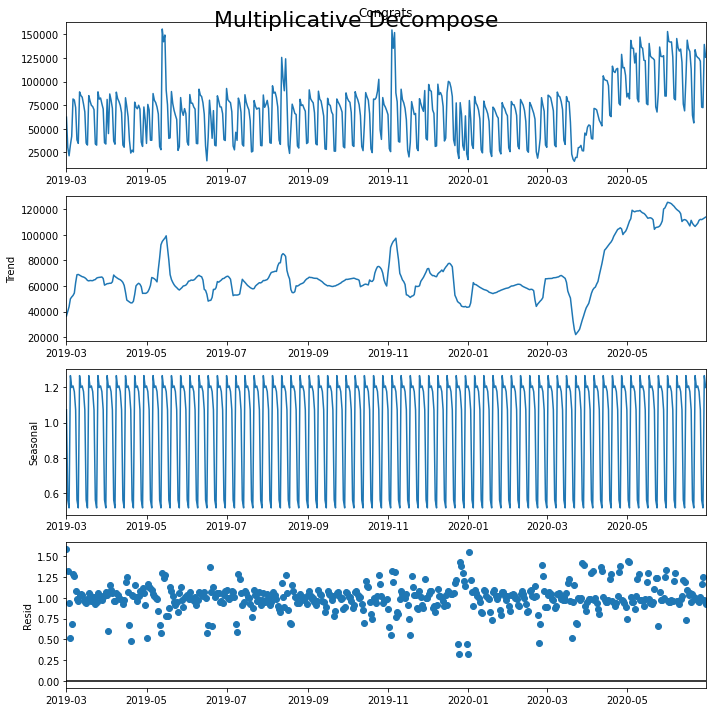

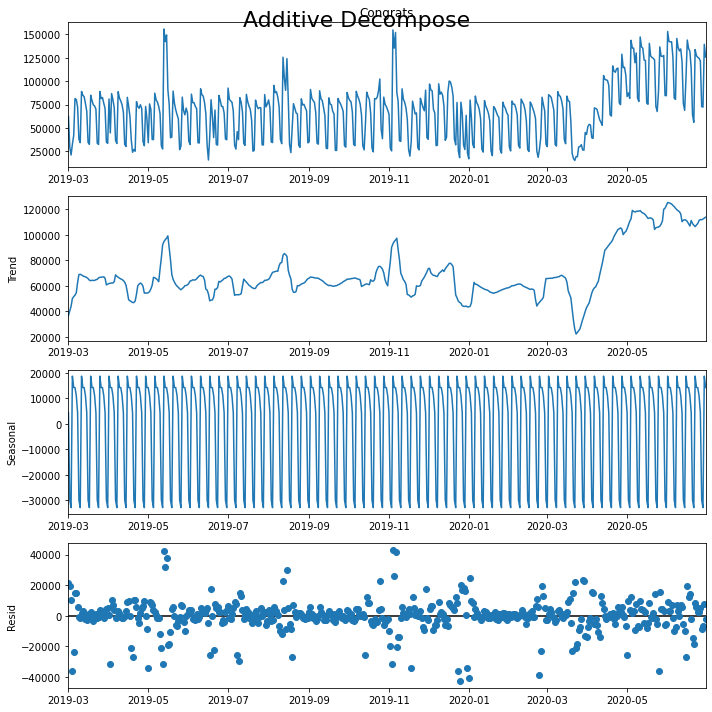

In [76]:
#Verificamos si también se trata de una serie aditiva o multiplicativa
# Multiplicative Decomposition 
result_mul_d = seasonal_decompose(df_traffic_desktop["Congrats"], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add_d = seasonal_decompose(df_traffic_desktop["Congrats"], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul_d.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add_d.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [77]:
# Extraemos los componentes multiplicativos
df_reconstructed = pd.concat([result_mul_d.seasonal, result_mul_d.trend, result_mul_d.resid, result_mul_d.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

seas                trend                resid  \
Fecha                                                                       
2019-03-01                 1.07            36,634.03                 1.58   
2019-03-02                 0.56            40,265.68                 1.33   
2019-03-03                 0.52            43,897.33                 0.94   
2019-03-04                 1.27            49,996.57                 0.51   
2019-03-05                 1.20            51,457.14                 0.68   

                  actual_values  
Fecha                            
2019-03-01            62,256.00  
2019-03-02            30,009.00  
2019-03-03            21,229.00  
2019-03-04            32,567.00  
2019-03-05            41,916.00

Al multiplicar los componentes multiplicativos vemos que el resultado es diferente al actual value, por lo que asumimos que también se trata de una serie aditiva.

In [78]:
# Extraemos los componentes aditivos
df_reconstructed = pd.concat([result_add_d.seasonal, result_add_d.trend, result_add_d.resid, result_add_d.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

seas                trend                resid  \
Fecha                                                                       
2019-03-01             4,359.90            36,634.03            21,262.07   
2019-03-02           -29,931.64            40,265.68            19,674.96   
2019-03-03           -32,924.34            43,897.33            10,256.01   
2019-03-04            18,789.86            49,996.57           -36,219.44   
2019-03-05            14,310.63            51,457.14           -23,851.78   

                  actual_values  
Fecha                            
2019-03-01            62,256.00  
2019-03-02            30,009.00  
2019-03-03            21,229.00  
2019-03-04            32,567.00  
2019-03-05            41,916.00

Verificamos que sumando los componentes obtenemos el valor de actual values.

<ipython-input-79-3a325fa53821>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[]

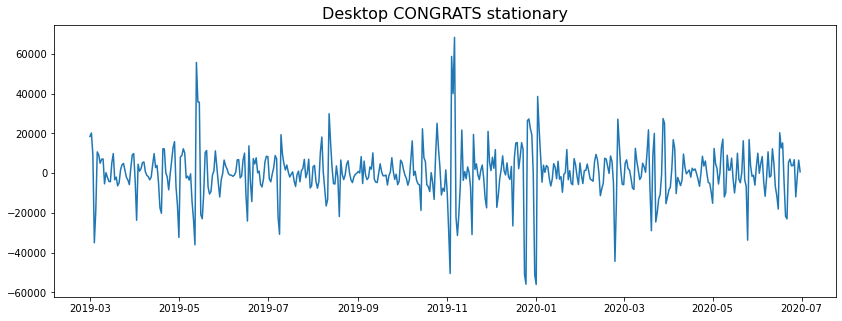

In [79]:
#Detrend
df_traffic_desktop["Congrats_stat"] = df_traffic_desktop["Congrats"].values - result_add_d.trend- result_add_d.seasonal
# Plot
plt.figure(figsize=(14,5))
plt.plot(df_traffic_android["Congrats_stat"])
plt.title('Desktop CONGRATS stationary', fontsize=16)
plt.plot()

**DESKTOP SHIPPING**

<ipython-input-80-3b833b174f7c>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[]

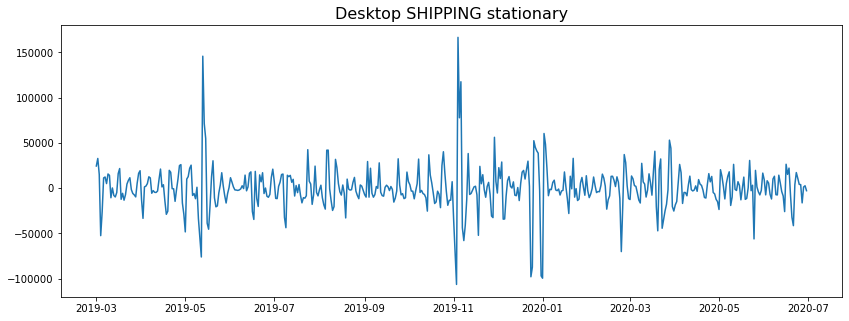

In [80]:
# Additive Decomposition
result_add_d = seasonal_decompose(df_traffic_desktop["Shipping"], model='additive', extrapolate_trend='freq')
#Detrend
df_traffic_desktop["Shipping_stat"] = df_traffic_desktop["Shipping"].values - result_add_d.trend- result_add_d.seasonal
# Plot
plt.figure(figsize=(14,5))
plt.plot(df_traffic_android["Shipping_stat"])
plt.title('Desktop SHIPPING stationary', fontsize=16)
plt.plot()

<ipython-input-81-85559ed07b65>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[]

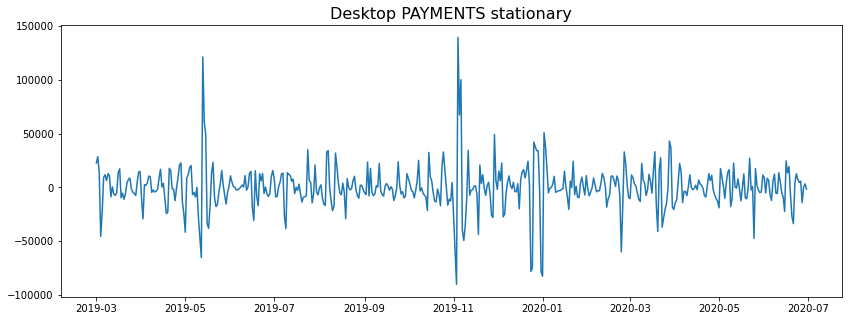

In [81]:
# Additive Decomposition
result_add_d = seasonal_decompose(df_traffic_desktop["Payments"], model='additive', extrapolate_trend='freq')
#Detrend
df_traffic_desktop["Payments_stat"] = df_traffic_desktop["Payments"].values - result_add_d.trend- result_add_d.seasonal
# Plot
plt.figure(figsize=(14,5))
plt.plot(df_traffic_android["Payments_stat"])
plt.title('Desktop PAYMENTS stationary', fontsize=16)
plt.plot()

<ipython-input-82-0a397a0586d6>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[]

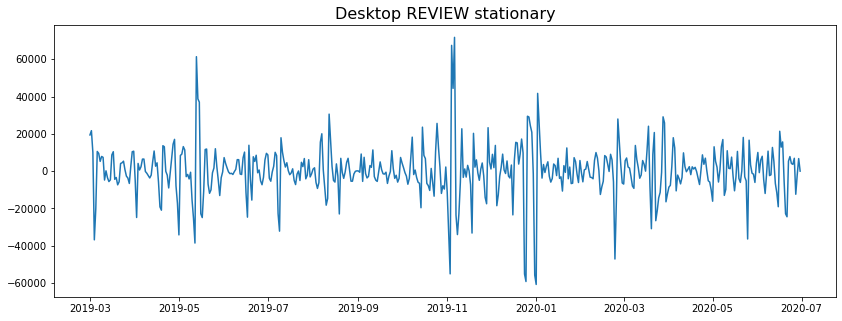

In [82]:
# Additive Decomposition
result_add_d = seasonal_decompose(df_traffic_desktop["Review"], model='additive', extrapolate_trend='freq')
#Detrend
df_traffic_desktop["Review_stat"] = df_traffic_desktop["Review"].values - result_add_d.trend- result_add_d.seasonal
# Plot
plt.figure(figsize=(14,5))
plt.plot(df_traffic_android["Review_stat"])
plt.title('Desktop REVIEW stationary', fontsize=16)
plt.plot()

UNA VEZ LOGRADAS LAS SERIES ESTACIONARIAS, TRABAJAREMOS CON LOS LOGARITMOS NATURALES Y LAS TASAS DE CONVERSION ENTRE ETAPAS


In [117]:
df_traffic= pd.concat([df_traffic_android, df_traffic_desktop])

In [118]:
#Agregamos una columna donde guardamos los valores transformados logarítmicamente
cols_etapas_slog=['Shipping_slog', 'Payments_slog', 'Review_slog', 'Congrats_slog']
cols_etapas_total = cols_etapas + cols_etapas_log + cols_etapas_stat + cols_etapas_slog 

#Realizamos la transformación de las etapas
df_traffic[cols_etapas_slog] = np.log(df_traffic[cols_etapas_stat])

# volvemos a definir los dos datasets de interes con las nuevas columnas
df_traffic_desktop = df_traffic[df_traffic.Device==("Desktop")]
df_traffic_android = df_traffic[df_traffic.Device==("Android")]

<ipython-input-118-3092219d6b13>:6: RuntimeWarning:

invalid value encountered in log



In [120]:
#Nuevamente, graficamos una etapa en particular transformada logarítmicamente tanto de Android como Desktop. Podemos ver tanto la tendencia como el comportamiento semanal se mantienen. 
fig3 = px.line(df_traffic, x= df_traffic.index , y= "Congrats_slog", color='Device').update_layout(yaxis_title="Número de usuarios en CONGRATS",  title={
        'text': "CONGRATS_SLOG",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig3.update_xaxes(rangeslider_visible=True)
fig3.show()

In [87]:
#Recalculamos las columnas de indice a partir de las etapas sin los componentes de season y trend
df_traffic["Shipping-Payments-stat"] = df_traffic["Payments_stat"] / df_traffic["Shipping_stat"]
df_traffic["Payments-Review-stat"] = df_traffic["Review_stat"] / df_traffic["Payments_stat"]
df_traffic["Review-Congrats-stat"] = df_traffic["Congrats_stat"] / df_traffic["Review_stat"]
df_traffic["Shipping-Congrats-stat"] = df_traffic["Congrats_stat"] / df_traffic["Shipping_stat"]

#agrupamos las columnas de índices para evaluar su comportamiento por separado de las etapas
cols_indices_stat = ['Shipping-Payments-stat', 'Payments-Review-stat', 'Review-Congrats-stat', 'Shipping-Congrats-stat']

In [108]:
#Recalculamos las columnas de indice sobre las transformadas log de las etapas ya sin las componentes de season y trend
df_traffic["Shipping-Payments-slog"] = df_traffic["Payments_slog"] / df_traffic["Shipping_slog"]
df_traffic["Payments-Review-slog"] = df_traffic["Review_slog"] / df_traffic["Payments_slog"]
df_traffic["Review-Congrats-slog"] = df_traffic["Congrats_slog"] / df_traffic["Review_slog"]
df_traffic["Shipping-Congrats-slog"] = df_traffic["Congrats_slog"] / df_traffic["Shipping_slog"]

#agrupamos las columnas de índices para evaluar su comportamiento por separado de las etapas
cols_indices_slog = ['Shipping-Payments-slog', 'Payments-Review-slog', 'Review-Congrats-slog', 'Shipping-Congrats-slog']

In [121]:
#Nuevamente, graficamos una etapa en particular transformada logarítmicamente tanto de Android como Desktop. Podemos ver tanto la tendencia como el comportamiento semanal se mantienen. 
fig3 = px.line(df_traffic, x= df_traffic.index , y= "Congrats_stat", color='Device').update_layout(yaxis_title="Número de usuarios en CONGRATS",  title={
        'text': "CONGRATS_STAT",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig3.update_xaxes(rangeslider_visible=True)
fig3.show()

Text(0.5, 1.0, 'stat-log')

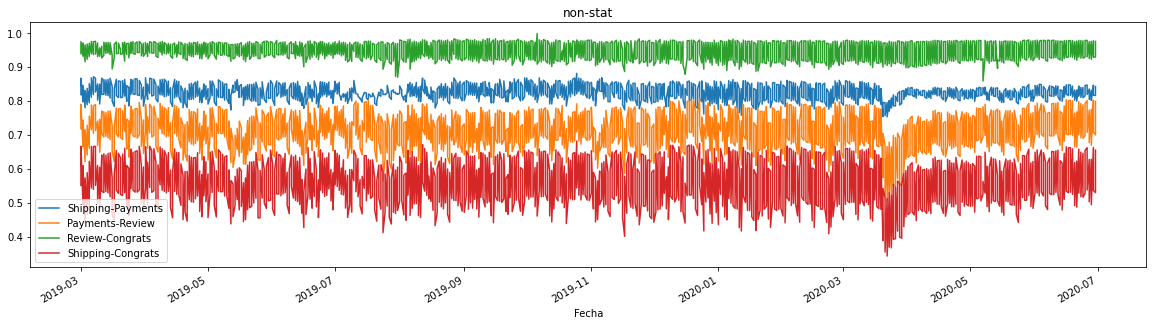

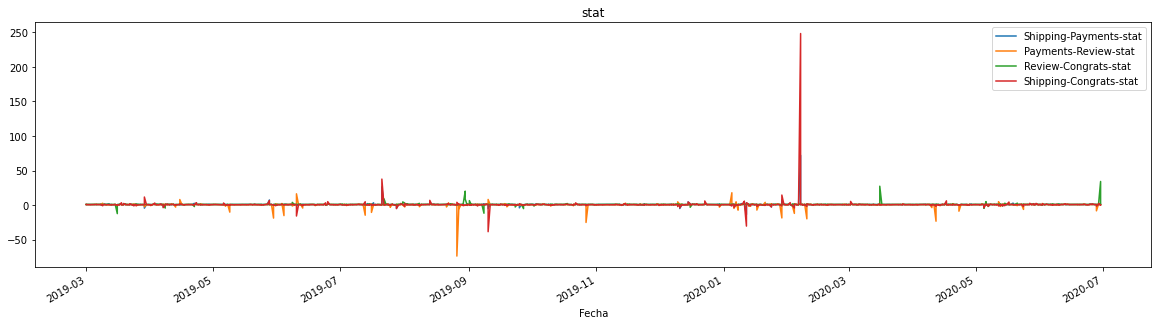

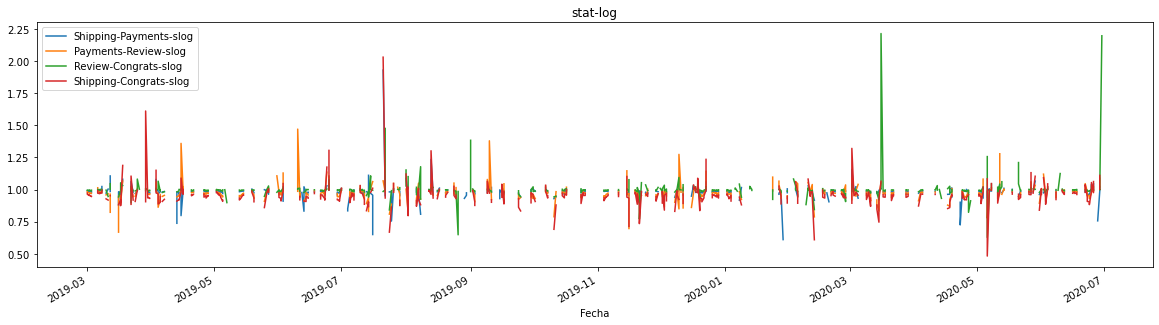

In [109]:
df_traffic[cols_indices].plot(  figsize=(20, 5)).set_title("non-stat")
df_traffic[cols_indices_stat].plot( figsize=(20, 5)).set_title("stat")
df_traffic[cols_indices_slog].plot( figsize=(20, 5)).set_title("stat-log")

In [125]:
#Nuevamente, graficamos un indice en particular  tanto de Android como Desktop. Podemos ver tanto la tendencia como el comportamiento semanal se mantienen. 
fig3 = px.line(df_traffic, x= df_traffic.index , y= "Shipping-Payments-stat", color='Device').update_layout(yaxis_title="Indice stac",  title={
        'text': "INDICES STACIONARIOS",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig3.update_xaxes(rangeslider_visible=True)
fig3.show()

In [123]:
#Nuevamente, graficamos un indice en particular transformado tanto de Android como Desktop. Podemos ver tanto la tendencia como el comportamiento semanal se mantienen. 
fig3 = px.line(df_traffic, x= df_traffic.index , y= "Shipping-Payments-slog", color='Device').update_layout(yaxis_title="Número de usuarios en CONGRATS",  title={
        'text': "INDICES STACIONARIOS",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig3.update_xaxes(rangeslider_visible=True)
fig3.show()

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['flow', 'Site', 'Device', 'Loading', 'Shipping', 'Payments', 'Review', 'Congrats', 'Shipping-Payments', 'Payments-Review', 'Review-Congrats', 'Shipping-Congrats', 'Weekday', 'Month', 'Year', 'Months', 'Shipping_log', 'Payments_log', 'Review_log', 'Congrats_log', 'Congrats_detrend', 'Congrats_deseas', 'Congrats_stat', 'Shipping_stat', 'Payments_stat', 'Review_stat', 'Shipping-Payments-stat', 'Payments-Review-stat', 'Review-Congrats-stat', 'Shipping-Congrats-stat', 'Shipping_slog', 'Payments_slog', 'Review_slog', 'Congrats_slog', 'payment_slog'] but received: Shipping-Payments-slog